<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

![](https://bloximages.newyork1.vip.townnews.com/dailynebraskan.com/content/tncms/assets/v3/editorial/e/19/e1994033-0f70-53ae-b737-27320f2433f0/51afb027be539.image.jpg)

# Install

In [1]:
!pip install transformers

# Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
import transformers as pb #pretrained bert

In [3]:
import warnings
warnings.filterwarnings('ignore')

# BERT

## HuggingFace

In [4]:
# Load models
model_class, tokenizer_class, pretrained_weights = (pb.BertModel, pb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer weights
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model     = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Config
* HuggingFace config yields details about the configuration of the transformer
  * Model Type
  * Hidden size 
  * Intermediate size
  * Attention heads
  * Number of layers
  * Vocabulary 
  * Max tokens 
  * Positional encoding

In [5]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Encoder Architecture
![](https://www.researchgate.net/publication/349546860/figure/fig2/AS:994573320994818@1614136166736/The-Transformer-based-BERT-base-architecture-with-twelve-encoder-blocks.ppm)

## Self Attention

## Intermediate Layers
* Sridhar (2020) - Undivided Attention: Are Intermediate Layers Necessary for BERT?  (https://arxiv.org/pdf/2012.11881.pdf)
* Paper doesn't find strong support for intermediate layers
* 1-2% Increase in loss / reduction in accuracy on common NLP tasks
* Removal of all intermediate layers reduces parameter size by 50% and increases throughput by 2.5X

## Masked Language Model
* Language model is a probability distribution over words or sequences (NGrams)
* MLM is a pre-training task where we hide a word and ask the model to predict the correct token
* MLM forces the model to learn the contextuality of a word
* MLM performs better than static word embeddings (i.e. polysemy) 
* Randomly select 15% of tokens for masking
  * 80% replaced with a [MASK]
  * 10% replace with a random word
  * 10% use the original word

## Next Sentence Prediction
* Uses this pattern [CLS] Sentence 1 [SEP] Sentence 2 [SEP]
* The model must then decide if Sentence 2 follows Sentence 1
* 50% of time, use next sentence, 50% use random sentence
* The goal is to force the model to reasoning and semantic understanding


## Tokenizer
* Tokenizer transforms sentences into an array of tokens
* BERT uses the WordPiece algorithm to break OOV into subwords
* BERT adds:
  * Token Types (Sentence 1 or Sentence 2)
  * Attention masking (Token or Padding)
  * Positional Encoding (in this model Absolute)
* Tokenizer decodes tokens back into text

In [6]:
# Break into words (i.e.WordPiece)
text1 = 'The quick brown fox jumped over the lazy dog'
tokenizer.tokenize(text1)

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

In [7]:
# WordPiece will break OOV word fragments that exist in the vocabulary
text2 = 'The quick brown fox jumped over the lazy martingale'
tokenizer.tokenize(text2)

['the',
 'quick',
 'brown',
 'fox',
 'jumped',
 'over',
 'the',
 'lazy',
 'martin',
 '##gal',
 '##e']

In [8]:
# Encoding will add extra tokens
# For BERT we start the text with [CLS] and send with [SEP]
tokens = tokenizer.encode(text1, add_special_tokens=True)
tokens

[101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3899, 102]

In [9]:
# Decoding will convert tokens back to text
tokenizer.decode(tokens)

'[CLS] the quick brown fox jumped over the lazy dog [SEP]'

## Padding and Masking
* Padding is an important concept
* Within a batch, we need to align the lengths of the sequences
* Padding handles the alignment
* BERT has a 512 token max length that it can process
* Note:  If you're training a LM or Fine Tuning one, match sequence lengths to speed up training


In [10]:
# Combine sentences into a batch
sentences = [text1, text2]

In [11]:
# With a batch all of our lists need to be the same size (2 dimensional array)
encoded = tokenizer(sentences)
print('Token Ids     ', encoded['input_ids'])
print('Token Type Ids', encoded['token_type_ids'])
print('Attention Mask', encoded['attention_mask'])

Token Ids      [[101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3899, 102], [101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3235, 9692, 2063, 102]]
Token Type Ids [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Attention Mask [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [12]:
# Token_Type_Ids tells BERT where the first / second sentence exists
# This is related to its next sentence prediction task
# Add padding and compare
nsp = [[text1, text2]]
encoded_nsp = tokenizer(nsp)
print('Token Ids.    ', encoded_nsp['input_ids'])
print('Token Type Ids', encoded_nsp['token_type_ids'])
print('Decoded       ', tokenizer.decode(encoded_nsp['input_ids'][0]))

Token Ids.     [[101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3899, 102, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3235, 9692, 2063, 102]]
Token Type Ids [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
Decoded        [CLS] the quick brown fox jumped over the lazy dog [SEP] the quick brown fox jumped over the lazy martingale [SEP]


In [13]:
# Attention Mask tells BERT where we've done padding (ignore)
# Padding = True (or longest) -> Pad the input to the max length
# Truncation will drop tokens past max length
# Padded tokens need to be masked for BERT (Attention Mask)
pad = [text1, text2]
padded = tokenizer(pad, padding=True, max_length=10, truncation=True)
print('Token Ids     ', padded['input_ids'])
print('Token Type Ids', padded['token_type_ids'])
print('Attention Mask', padded['attention_mask'])

Token Ids      [[101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 102], [101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 102]]
Token Type Ids [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Attention Mask [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


## Tensors
* BERT is a deep learning model
* Has robust support for both TensorFlow and PyTorch

In [14]:
## Huggingface supports TensorFlow and PyTorch
returned = [text1, text2]
tf = tokenizer(returned, return_tensors='tf', padding=True)
print('Token Ids     ', tf['input_ids'])
print('Token Type Ids', tf['token_type_ids'])
print('Attention Mask', tf['attention_mask'])

Token Ids      tf.Tensor(
[[  101  1996  4248  2829  4419  5598  2058  1996 13971  3899   102     0
      0]
 [  101  1996  4248  2829  4419  5598  2058  1996 13971  3235  9692  2063
    102]], shape=(2, 13), dtype=int32)
Token Type Ids tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(2, 13), dtype=int32)
Attention Mask tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]], shape=(2, 13), dtype=int32)


In [15]:
## Huggingface also supports PyTorch
returned = [text1, text2]
pt = tokenizer(returned, return_tensors='pt', padding=True)
print('Token Ids     ', pt['input_ids'])
print('Token Type Ids', pt['token_type_ids'])
print('Attention Mask', pt['attention_mask'])

Token Ids      tensor([[  101,  1996,  4248,  2829,  4419,  5598,  2058,  1996, 13971,  3899,
           102,     0,     0],
        [  101,  1996,  4248,  2829,  4419,  5598,  2058,  1996, 13971,  3235,
          9692,  2063,   102]])
Token Type Ids tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Attention Mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


## Contextualize
* Contextualizing means generating the word vectors based on the words in the sentence
* The architecture of BERT generates a vector for the [CLS] token
* The [CLS] token's vector is a summary over the sentence

In [16]:
# Contexualize text through BERT
sentence  = [text1]
tokenized = tokenizer(sentence, return_tensors='pt', padding=True)
contextualized = model(tokenized['input_ids'], attention_mask=tokenized['attention_mask'])

print('Tokens Size ', tokenized['input_ids'].shape)
print('Hidden Size ', contextualized['last_hidden_state'].shape)
print('Pooler Size ', contextualized['pooler_output'].shape)

Tokens Size  torch.Size([1, 11])
Hidden Size  torch.Size([1, 11, 768])
Pooler Size  torch.Size([1, 768])


In [17]:
# Hidden states are of size (hidden) and one is generated for each token
contextualized['last_hidden_state']

tensor([[[-0.2228,  0.0073,  0.0482,  ..., -0.1574,  0.3288,  0.2621],
         [-0.1737, -0.4096, -0.4983,  ..., -0.1880,  1.2044, -0.2952],
         [-0.2977, -0.3981,  0.3797,  ..., -0.2138,  0.6636, -0.1649],
         ...,
         [-0.1303, -0.1154,  0.6148,  ...,  0.1015,  0.5442, -0.3730],
         [-0.1986, -0.2065, -0.4074,  ...,  0.3007,  0.4622,  0.2973],
         [ 0.6165, -0.0107, -0.5845,  ..., -0.0135, -0.4108, -0.2058]]],
       grad_fn=<NativeLayerNormBackward0>)

In [18]:
# Pooler Output is centered on the CLS token
# This can be thought of as an "embedding for the sentence"
contextualized['pooler_output']

tensor([[-5.9401e-01, -1.0135e-01,  7.4267e-01,  2.0509e-01, -4.7075e-01,
          5.0425e-02,  7.1633e-01,  1.0121e-01,  5.9343e-01, -9.9764e-01,
          4.6877e-01, -4.8997e-01,  9.5637e-01, -5.3000e-01,  8.4247e-01,
         -1.2446e-01,  2.8013e-01, -3.3503e-01,  1.2903e-01, -4.6546e-01,
          3.8562e-01,  3.3221e-02,  7.0234e-01,  7.4542e-02,  2.0121e-01,
         -6.1849e-01, -2.0614e-01,  8.3249e-01,  8.9590e-01,  5.4019e-01,
         -3.4995e-01,  2.4872e-02, -9.5590e-01, -4.4388e-02,  7.3188e-01,
         -9.2596e-01, -9.9329e-02, -5.8222e-01,  6.8173e-02,  1.0857e-01,
         -7.4663e-01,  9.7963e-02,  9.5256e-01, -3.8399e-01, -3.1924e-01,
         -2.4076e-01, -9.1113e-01,  1.2108e-01, -7.3049e-01, -7.3746e-01,
         -6.3056e-01, -7.7027e-01, -5.7029e-02,  1.2736e-01,  1.6882e-01,
          5.7926e-01, -2.5639e-01,  3.3097e-03,  4.6049e-02, -3.1789e-01,
         -4.5671e-01, -1.7132e-02,  4.9119e-01, -7.0586e-01, -6.6945e-01,
         -8.1122e-01,  4.2862e-02, -4.

## Fine Tuning
* BERT was trained on MLM and NSP
* These tasks do a good job building contextualized word embeddings
* They are not designed for all tasks, specifically the upper layers of BERT need to be "adjusted" to specific problems

# What does BERT know?



## Sources
* Rodgers et. al. (2020) A Primer in BERTology: What we know about how BERT works (https://arxiv.org/abs/2002.12327)
* Kovaleva et. al. (2019) Revealing the Dark Secrets of BERT (https://aclanthology.org/D19-1445/)
* Jawahar et. al. (2019) What does BERT Learn about the Structure of Language (https://aclanthology.org/P19-1356/)
* Goldberg (2019) Assessing BERT's Syntactic Abilities (https://arxiv.org/abs/1901.05287)
* Tenney et. al. (2019) BERT Rediscovers the Classical NLP Piepleine (https://arxiv.org/abs/1905.05950)
* Hewitt, Manning (2019) A Structural Probe for Finding Syntax in Word Representations (https://nlp.stanford.edu/pubs/hewitt2019structural.pdf)
* Ethayarajh (2019) How Contextual are Contextualized Word Representations?  Comparing the Geometry of BERT, ELMo and GPT-2 Embeddings (https://arxiv.org/pdf/1909.00512)
* Gordon (2020) Compressing BERT: Studying the Effects of Weight Pruning on Transfer Learning (https://aclanthology.org/2020.repl4nlp-1.18/)

## Probing Tasks
* Train a linear model to predict semantic and syntactic properties of words
* Based on the idea that if a simple model can predict a linguistic property then the representation implicitly encodes this capability
* Examples:
  * Shallow - Word Count / Sentence Length
  * Syntactic - Parse Depth
  * Semantic - 

![](https://nlp.stanford.edu//~johnhew//public/ct/probing-diagram.png)

## BERT Embeddings
* BERT makes conical embeddings (Anisotropic)
* Look at same word in different contexts (sentences)
* Cosine similarity of two random are very close
* Cosine similarity tends to get closer in later layers

## BERT Layers
* BERT lower layers learn shallow features
* Intermediate layers learn syntactic features
* Final layers are most task-specific
  * These will have been trained on MLM & NSP 
  * Fine-Tune to make them useful

## BERT Self-Attention 
* Attention heads tend to form one of five patterns
* Attention heads often are redundant (perhaps due to dropout)


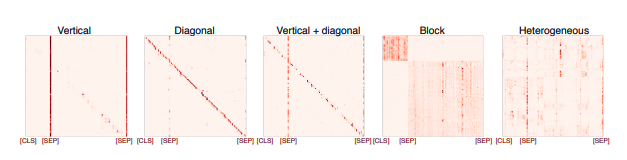

* BERT heads appear to have a form of specialization
* No one head has all the syntactic tree information, it's spread across heads / layers


## Syntactic Knowledge
* BERT representations are hierarchical (not linear) and not directly encoded in self-attention weights
* May need more layers to handle longer connections
* Ttakes subject - predicate agreement into account during the cloze task
* Fails to undetstand negation



## Semantic Knowledge
* BERT encodes information about entity types, relations, roles and proto-roles
* Doesn't work with numbers well
* Not strong in named entity replacement

## World Knowledge
* BERT cannot reason based on world knowledge
* Struggles with inference and role-based event knowledge
* Competitive on some relation types

## Architecture & Training
* BERT number of layers more important than number of heads
* Larger batch size improves model (more noise)
* Can be trained in recursive manner (warmup)
* Train 

## Pre-Training
![](https://www.mindspore.cn/tutorial/training/en/r1.2/_images/bert_model.PNG)

* BERT's pre-training can be significantly improved
  * Phrase span masking
  * Named entity masking
  * Train longer, larger batch size
* BERT's NSP task isn't very valuable 

## Fine-Tuning
![](https://www.researchgate.net/profile/Lukas-Muttenthaler/publication/342197300/figure/fig2/AS:902897298571264@1592278899283/BERT-fine-tuning-21.ppm)

* BERT should be fine tuned to domain and task - default final layers are task specific (i.e. MLM and NSP)
  * During fine tuning last layers undergo the most change
  
* Consider more layers than just the final when fine-tuning BERT
* Consider two-stage fine-tuning
  * Train unsupervised on unlabeled domain text
  * Fine tune supervised
* Run few epochs (2-4) to avoid overfitting

## Overparameterization
* Gordon (2020) 30-40% of weights can be pruned without hurting downstream tasks
  * Even BERTsmall is overparameterized
  * Intermediate layers can be omitted
* BERT can be compressed without compromisizng accuracy
  * Train large model on large data then compress
  * Strategies
    * Knowledge Distillation (Student-Teacher - DistBERT)
    * Quantization (Reduce floating point precision)
    * Pruning (Drop layers, Share Layers, Drop Nodes)